## Intro to Scalable Computing with Dask in Python - 2
(currently only 1/2 of video is represented here)

https://www.youtube.com/watch?v=GEdhmCjBBbQ

Use `PythonNotes/env/dask.yaml` to create an environment for this notebook:
```
conda env create -f [PythonNotes/env/dask.yaml]
```
or

```
conda activate dask
```

## Load data

In [1]:
import os
import pandas as pd
# path used as base for file I/O for this notebook
home = '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/'
# path for "play-data" 
file_dir  = '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.csv'
# use thousands = ',' to import numbers as numbers rather than strings
df = pd.read_csv(
    os.path.join(file_dir, file_name), 
    thousands=','
)
df.head() # shows first 5-lines of .csv file

,AntID,Company,EntryDateTime,HrsBetweenEnryAndTransfer,StartDateTime,Duration,Deliverer,Receiver,IsRegulatedReceiverFlag,Location,...,TransferQtyInGallon,TransferType,IsPreboomed,IsTransferRateGT500,ContactName,ContactPhone,DelivererTypeDescription,ReceiverTypeDescription,RemarksDescription,TotalVolume
0,173454,Maxum - Harbor Island Terminal,12/27/17 11:25,115,1/1/18 6:15,1.0,Maxum (Rainer Petroleum),VICTORIA CLIPPER IV,Y,SEATTLE MAXUM PETROLEUM (EX RAINIER),...,2500,Fueling,NaN,NaN,Paul Lusk,206-613-1442,Facility,PASSENGER SHIP,NaN,10908976886
1,173466,Seaport Midstream Partners LLC,12/27/17 17:50,134,1/2/18 7:00,4.0,TLP Management Services LLC (TMS),GLOBAL PILOT,Y,SEATTLE HARBOR ISLAND PIER 11 (EX-BP),...,546000,Cargo,Y,Y,Sammy Makalena,2066234635 x28,Facility,TANK BARGE,NaN,10908976886
2,173482,PHILLIPS 66 - FERNDALE REFINERY,12/28/17 9:34,91,1/1/18 4:30,12.0,POLAR RESOLUTION,Phillips 66 Ferndale Refinery,Y,FERNDALE PHILLIPS 66,...,12390000,Cargo,Y,Y,Michael J Cherochak,360 384 7822,TANK SHIP,Facility,NaN,10908976886
3,173484,PHILLIPS 66 - FERNDALE REFINERY,12/28/17 9:44,118,1/2/18 7:00,8.0,Phillips 66 Ferndale Refinery,NATHAN SCHMIDT,Y,FERNDALE PHILLIPS 66,...,1176000,Cargo,Y,Y,Michael J Cherochak,360 384 7822,Facility,TANK BARGE,NaN,10908976886
4,173489,BP CHERRY POINT REFINERY,12/28/17 11:03,117,1/2/18 8:00,15.0,SKS SEGURA,BP Cherry Point Refinery,Y,CHERRY POINT BP,...,8820000,Cargo,Y,Y,Justin McCartney,360-371-1321,TANK SHIP,Facility,NaN,10908976886


In [2]:
len(df)

14710

In [3]:
df.dtypes

AntID                          int64
Company                       object
EntryDateTime                 object
HrsBetweenEnryAndTransfer      int64
StartDateTime                 object
Duration                     float64
Deliverer                     object
Receiver                      object
IsRegulatedReceiverFlag       object
Location                      object
StreetAddress                 object
LatNumber                    float64
LongNumber                   float64
City                          object
Region                        object
Product                       object
TransferQtyInGallon            int64
TransferType                  object
IsPreboomed                   object
IsTransferRateGT500           object
ContactName                   object
ContactPhone                  object
DelivererTypeDescription      object
ReceiverTypeDescription       object
RemarksDescription            object
TotalVolume                    int64
dtype: object

In [4]:
df.Deliverer.unique()  #NOT the best example of when to use unique!

array(['Maxum (Rainer Petroleum)', 'TLP Management Services LLC (TMS)',
       'POLAR RESOLUTION', 'Phillips 66 Ferndale Refinery', 'SKS SEGURA',
       'ITB ISLAND TRADER', 'Shell Puget Sound Refinery',
       'Tidewater Snake River Terminal', 'EXPLORER', 'Pacific Ethanol',
       'Nelson Petroleum', 'Pacific Functional Fluids, LLC',
       'U.S. Oil & Refining', 'PROFESSOR KAREN ANN BROWN',
       'Tesoro Port Angeles Terminal', 'HMS 2000', 'HMS 2604', 'HMS 26-1',
       'DR. BONNIE W. RAMSEY', 'Reisner Distributor, Inc.',
       'GLOBAL PILOT', 'ALASKAN NAVIGATOR', 'ATB BARGE 650-10', 'WARRIOR',
       'Naval FISC Manchester Fuel Depot (Mobile)', 'YON-326',
       'Naval Base Kitsap at Bremerton',
       'Kinder Morgan Liquids Terminal - Harbor Island',
       'Covich Williams Co Inc', 'BETSY ARNTZ',
       'Tidewater Vancouver Terminal', 'Connell Oil Inc',
       'BP Cherry Point Refinery', 'NATHAN SCHMIDT',
       'Alon Asphalt Company (Paramount Petroleum)',
       'Andeavor Anac

In [5]:
# first convert transfer quantity to gallons and then take mean accordign to deliverer
df.TransferQtyInGallon = df.TransferQtyInGallon.astype(float)
meanDelivery = df.groupby('Deliverer').TransferQtyInGallon.mean()

In [6]:
meanDelivery

Deliverer
  USCG MELON        3.500000e+03
 MT PICHINCHA       8.400000e+06
ALASKA VICTORY      3.500000e+03
ALASKAN EXPLORER    2.028053e+07
ALASKAN FRONTIER    1.419034e+07
                        ...     
atlantic sirius     3.280700e+06
global provider     6.056500e+03
global prrovider    5.150000e+03
thiessen oil        2.500000e+04
thiesson oil        2.500000e+03
Name: TransferQtyInGallon, Length: 339, dtype: float64

## The next part brings in information from multiple files, so we first need to create multiple files. I do so here by creating monthly data files

### Question: what is the average per month?

In [7]:
# note: I'm not sure if data is in PST or UTC...but this will serve as an example
df.EntryDateTime = df.EntryDateTime.astype('datetime64[ns, US/Pacific]')
df.TransferQtyInGallon = df.TransferQtyInGallon.astype(float)
df

,AntID,Company,EntryDateTime,HrsBetweenEnryAndTransfer,StartDateTime,Duration,Deliverer,Receiver,IsRegulatedReceiverFlag,Location,...,TransferQtyInGallon,TransferType,IsPreboomed,IsTransferRateGT500,ContactName,ContactPhone,DelivererTypeDescription,ReceiverTypeDescription,RemarksDescription,TotalVolume
0,173454,Maxum - Harbor Island Terminal,2017-12-27 11:25:00-08:00,115,1/1/18 6:15,1.0,Maxum (Rainer Petroleum),VICTORIA CLIPPER IV,Y,SEATTLE MAXUM PETROLEUM (EX RAINIER),...,2500.0,Fueling,NaN,NaN,Paul Lusk,206-613-1442,Facility,PASSENGER SHIP,NaN,10908976886
1,173466,Seaport Midstream Partners LLC,2017-12-27 17:50:00-08:00,134,1/2/18 7:00,4.0,TLP Management Services LLC (TMS),GLOBAL PILOT,Y,SEATTLE HARBOR ISLAND PIER 11 (EX-BP),...,546000.0,Cargo,Y,Y,Sammy Makalena,2066234635 x28,Facility,TANK BARGE,NaN,10908976886
2,173482,PHILLIPS 66 - FERNDALE REFINERY,2017-12-28 09:34:00-08:00,91,1/1/18 4:30,12.0,POLAR RESOLUTION,Phillips 66 Ferndale Refinery,Y,FERNDALE PHILLIPS 66,...,12390000.0,Cargo,Y,Y,Michael J Cherochak,360 384 7822,TANK SHIP,Facility,NaN,10908976886
3,173484,PHILLIPS 66 - FERNDALE REFINERY,2017-12-28 09:44:00-08:00,118,1/2/18 7:00,8.0,Phillips 66 Ferndale Refinery,NATHAN SCHMIDT,Y,FERNDALE PHILLIPS 66,...,1176000.0,Cargo,Y,Y,Michael J Cherochak,360 384 7822,Facility,TANK BARGE,NaN,10908976886
4,173489,BP CHERRY POINT REFINERY,2017-12-28 11:03:00-08:00,117,1/2/18 8:00,15.0,SKS SEGURA,BP Cherry Point Refinery,Y,CHERRY POINT BP,...,8820000.0,Cargo,Y,Y,Justin McCartney,360-371-1321,TANK SHIP,Facility,NaN,10908976886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14705,187124,MASCO PETROLEUM,2019-01-03 11:06:00-08:00,-68,12/31/18 15:45,1.0,PetroCard Inc - Westport Fuel Dock,The Sore Thumb,NaN,WESTPORT FUEL DOCK,...,250.0,Fueling,NaN,NaN,Rebecca Ames,360-407-7483,Facility,Un-regulated Vessel,NaN,10908976886
14706,187170,BALLARD OIL CO.,2019-01-04 10:56:00-08:00,-146,12/29/18 8:00,6.0,Ballard Oil Co.,CONSTELLATION,NaN,SEATTLE BALLARD OIL DOCK,...,39984.0,Fueling,NaN,NaN,Rebecca Ames,360-407-7483,Facility,NOT COVERED VESSEL,NaN,10908976886
14707,187170,BALLARD OIL CO.,2019-01-04 10:56:00-08:00,-146,12/29/18 8:00,6.0,Ballard Oil Co.,CONSTELLATION,NaN,SEATTLE BALLARD OIL DOCK,...,504.0,Other (incl Lube/Hyd Oil),NaN,NaN,Rebecca Ames,360-407-7483,Facility,NOT COVERED VESSEL,NaN,10908976886
14708,187170,BALLARD OIL CO.,2019-01-04 10:56:00-08:00,-146,12/29/18 8:00,6.0,Ballard Oil Co.,CONSTELLATION,NaN,SEATTLE BALLARD OIL DOCK,...,504.0,Other (incl Lube/Hyd Oil),NaN,NaN,Rebecca Ames,360-407-7483,Facility,NOT COVERED VESSEL,NaN,10908976886


In [8]:
df_bymonth = {}
month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
for month_index in range(12):
    df_bymonth = df[df['EntryDateTime'].dt.month == month_index+1]
    df_bymonth.to_csv(os.path.join(home,'data/DOE',f'DOE_bymonth_{month[month_index]}.csv'))
    del df_bymonth

### Sequential code with for loop to read in multiple files

In [9]:
from glob import glob
filenames = sorted(glob(os.path.join(home,'data/DOE',"*.csv")))
filenames

['/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_apr.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_aug.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_dec.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_feb.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_jan.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_jul.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_jun.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_mar.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_may.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_nov.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_oct.csv',

In [10]:
%%time
import numpy as np
sums = []
counts = []
for fn in filenames:
    df = pd.read_csv(fn)
    by_origin = df.groupby('Deliverer')
    total = by_origin.TransferQtyInGallon.sum()
    count = by_origin.TransferQtyInGallon.count()
    
    sums.append(total)
    counts.append(count)
    
total_gallons = sum(sums)
total_transfers = sum(counts)
mean = total_gallons / total_transfers
mean

CPU times: user 203 ms, sys: 28.9 ms, total: 232 ms
Wall time: 237 ms


Deliverer
  USCG MELON       NaN
 MT PICHINCHA      NaN
ALASKA VICTORY     NaN
ALASKAN EXPLORER   NaN
ALASKAN FRONTIER   NaN
                    ..
atlantic sirius    NaN
global provider    NaN
global prrovider   NaN
thiessen oil       NaN
thiesson oil       NaN
Name: TransferQtyInGallon, Length: 339, dtype: float64

#### NOTE: These NaNs shouldn't be here but my go-to nansum isn't doing the trick and I'm moving on :-)

#### Parallelize with dask.delayed

In [11]:
%%time
from dask import delayed

sums = []
counts = []
for fn in filenames:
    # setting a delayed object makes all subsequent delayed as well 
    df = delayed(pd.read_csv(fn))
    by_origin = df.groupby('Deliverer')
    total = by_origin.TransferQtyInGallon.sum()
    count = by_origin.TransferQtyInGallon.count()
    
    sums.append(total)
    counts.append(count)
    
total_gallons = delayed(sum)(sums)
total_transfers = delayed(sum)(counts)
mean = total_gallons / total_transfers
mean.compute()


CPU times: user 422 ms, sys: 80.9 ms, total: 503 ms
Wall time: 554 ms


Deliverer
  USCG MELON       NaN
 MT PICHINCHA      NaN
ALASKA VICTORY     NaN
ALASKAN EXPLORER   NaN
ALASKAN FRONTIER   NaN
                    ..
atlantic sirius    NaN
global provider    NaN
global prrovider   NaN
thiessen oil       NaN
thiesson oil       NaN
Name: TransferQtyInGallon, Length: 339, dtype: float64

#### NOTE: Not a great example.  We don't save time here

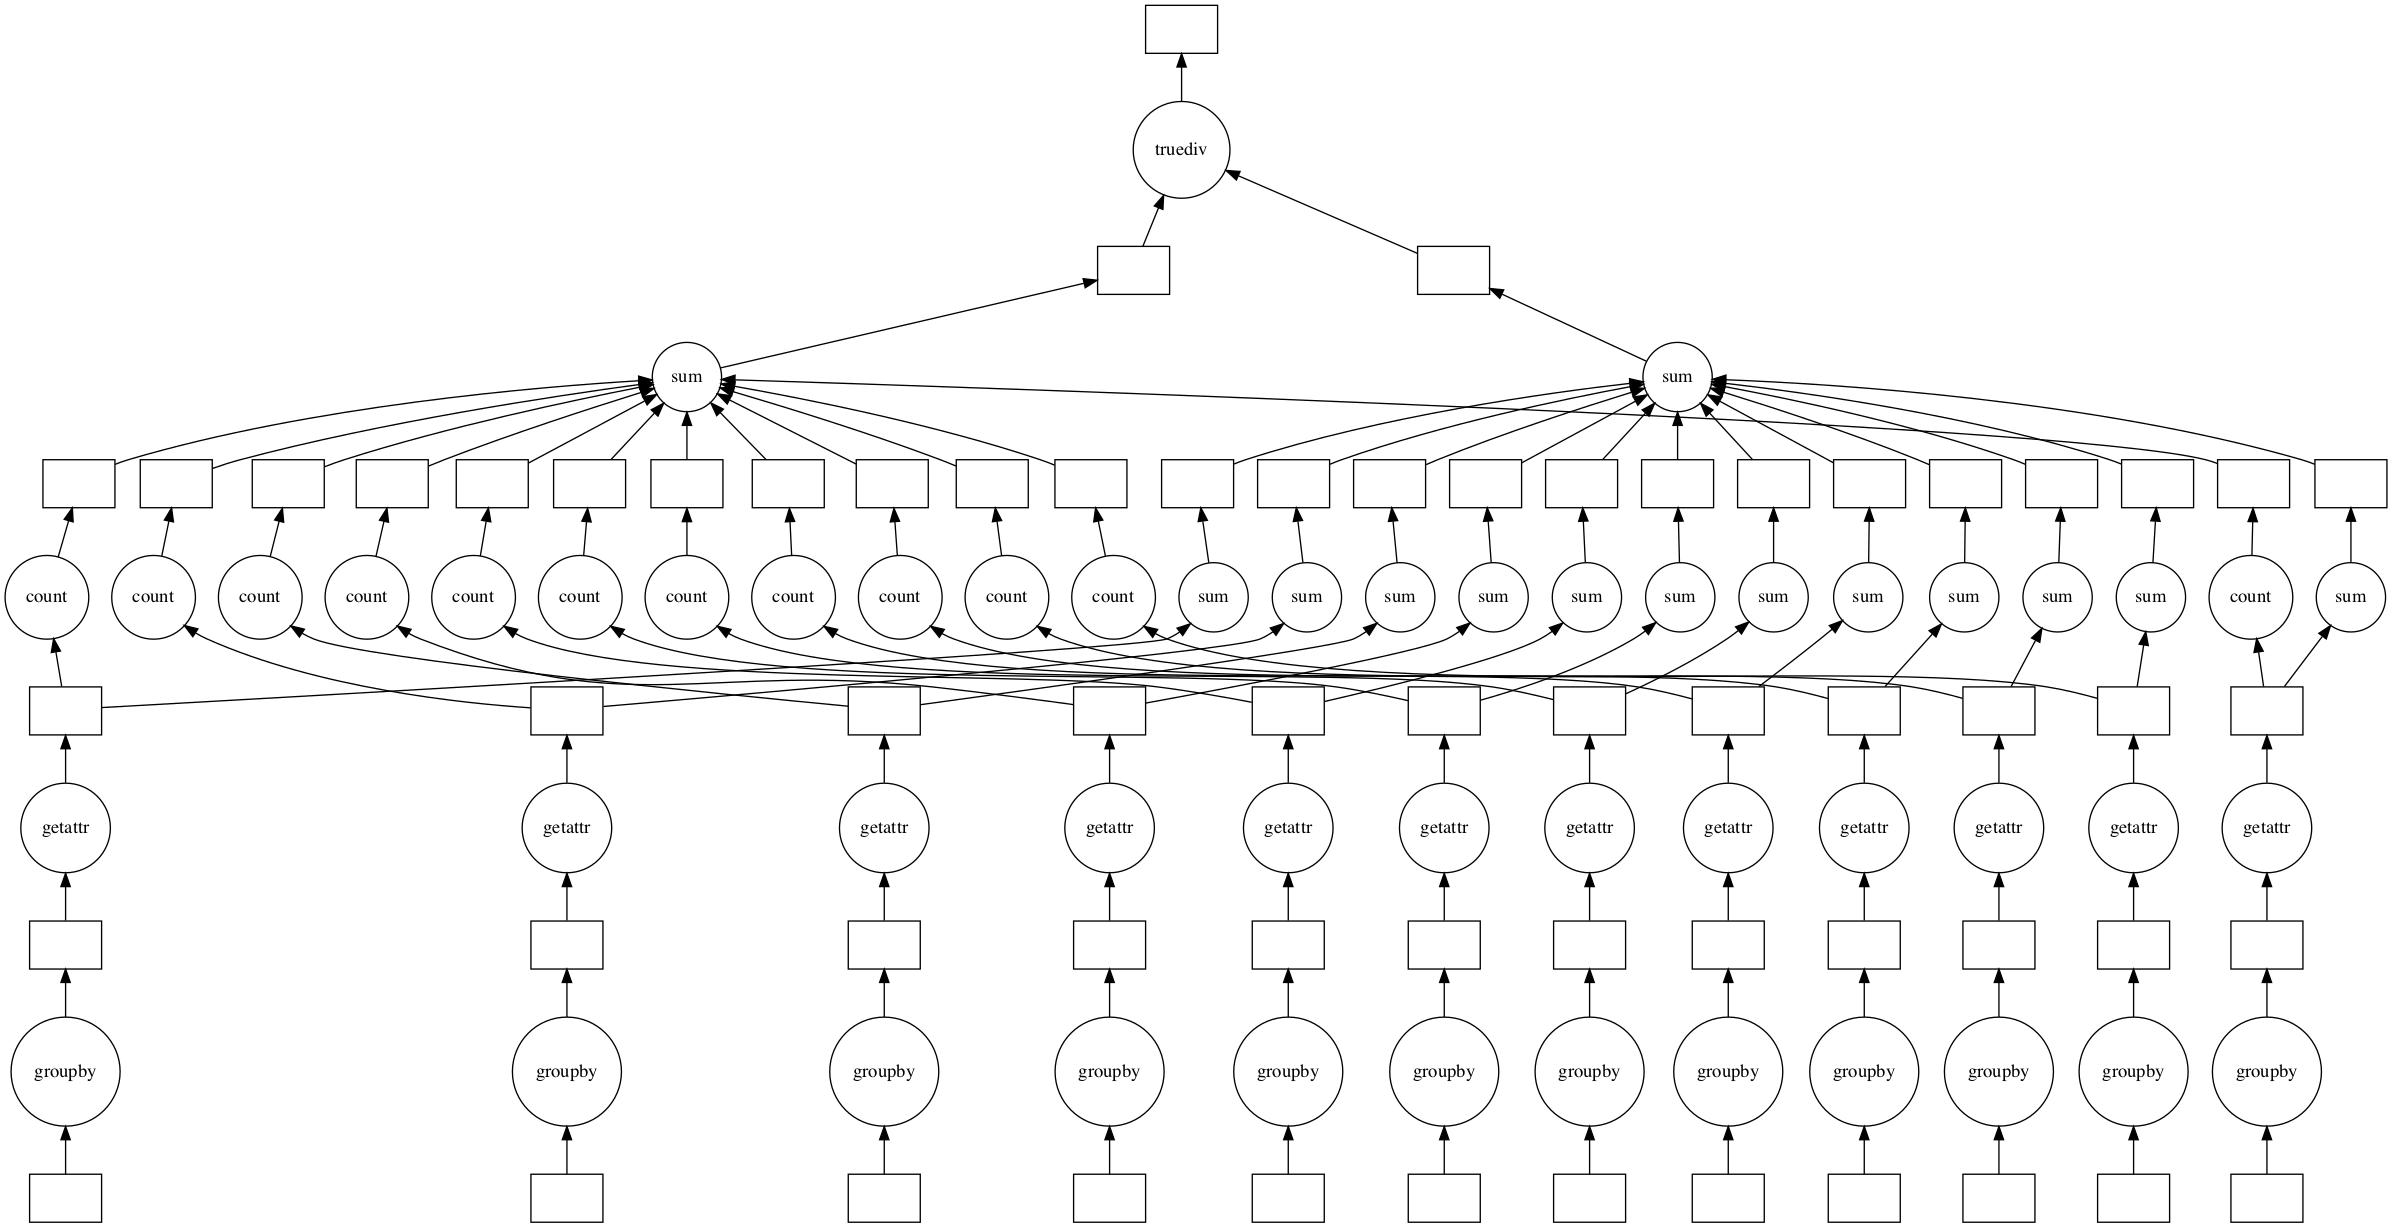

In [12]:
mean.visualize()

### Solution 3: Computation with dask.dataframe
Looks like Pandas dataframe but with lazy evaluation like dask.Delayed()
dask.dataframe.read_csv() can take a string for multiple files

In [13]:
import dask.dataframe as dd
df = dd.read_csv(os.path.join(home,'data/DOE',"*.csv"))
df

,Unnamed: 0,AntID,Company,EntryDateTime,HrsBetweenEnryAndTransfer,StartDateTime,Duration,Deliverer,Receiver,IsRegulatedReceiverFlag,Location,StreetAddress,LatNumber,LongNumber,City,Region,Product,TransferQtyInGallon,TransferType,IsPreboomed,IsTransferRateGT500,ContactName,ContactPhone,DelivererTypeDescription,ReceiverTypeDescription,RemarksDescription,TotalVolume
npartitions=12,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,object,object,int64,object,float64,object,object,object,object,object,float64,float64,object,object,object,float64,object,object,object,object,object,object,object,object,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Unlike pandas, dask.dataframe only reads part of data from beginning of file to parse data and column name and datatype is forced for the rest of entries.  Same kinds of queries apply as with pandas.dataframe:

In [14]:
df.dtypes

Unnamed: 0                     int64
AntID                          int64
Company                       object
EntryDateTime                 object
HrsBetweenEnryAndTransfer      int64
StartDateTime                 object
Duration                     float64
Deliverer                     object
Receiver                      object
IsRegulatedReceiverFlag       object
Location                      object
StreetAddress                 object
LatNumber                    float64
LongNumber                   float64
City                          object
Region                        object
Product                       object
TransferQtyInGallon          float64
TransferType                  object
IsPreboomed                   object
IsTransferRateGT500           object
ContactName                   object
ContactPhone                  object
DelivererTypeDescription      object
ReceiverTypeDescription       object
RemarksDescription            object
TotalVolume                    int64
d

In [15]:
df.head()

,Unnamed: 0,AntID,Company,EntryDateTime,HrsBetweenEnryAndTransfer,StartDateTime,Duration,Deliverer,Receiver,IsRegulatedReceiverFlag,...,TransferQtyInGallon,TransferType,IsPreboomed,IsTransferRateGT500,ContactName,ContactPhone,DelivererTypeDescription,ReceiverTypeDescription,RemarksDescription,TotalVolume
0,3155,176509,Maxum - Harbor Island Terminal,2018-04-02 07:45:00-07:00,3,4/2/18 10:00,1.0,Maxum (Rainer Petroleum),GOODTIME II,NaN,...,2000.0,Fueling,NaN,NaN,Paul Lusk,206-613-1442,Facility,Un-regulated Vessel,NaN,10908976886
1,3156,176510,"COVICH WILLIAMS COMPANY, INC.",2018-04-02 07:54:00-07:00,2,4/2/18 9:30,2.0,Covich Williams Co Inc,ocean titan,NaN,...,700.0,Other (incl Lube/Hyd Oil),NaN,NaN,Bob Williams,206504-9422,Mobile,Un-regulated Vessel,NaN,10908976886
2,3157,176511,MASCO PETROLEUM,2018-04-02 11:30:00-07:00,-70,3/30/18 13:05,1.0,PetroCard Inc - Westport Fuel Dock,Beverlee H,NaN,...,300.0,Fueling,NaN,NaN,Rebecca Ames,360-407-7483,Facility,Un-regulated Vessel,NaN,10908976886
3,3158,176512,MASCO PETROLEUM,2018-04-02 11:33:00-07:00,-68,3/30/18 15:10,1.0,PetroCard Inc - Westport Fuel Dock,Tornado,NaN,...,360.0,Fueling,NaN,NaN,Rebecca Ames,360-407-7483,Facility,Un-regulated Vessel,NaN,10908976886
4,3159,176513,MASCO PETROLEUM,2018-04-02 11:35:00-07:00,-68,3/30/18 15:50,1.0,PetroCard Inc - Westport Fuel Dock,Slammer,NaN,...,280.0,Fueling,NaN,NaN,Rebecca Ames,360-407-7483,Facility,Un-regulated Vessel,NaN,10908976886


In [16]:
len(df)

14710

### Now calculate average fuel transfers using dask.dataframe

In [17]:
%%time
# using dask.dataframe without loop

import dask.dataframe as dd
df = dd.read_csv(os.path.join(home,'data/DOE',"*.csv"))
# With this particular file, we need to specify the type as numeric
df.TransferQtyInGallon = df.TransferQtyInGallon.astype(float)
# delayed average computation for all files
mean = df.groupby('Deliverer').TransferQtyInGallon.mean()
mean.compute()

CPU times: user 468 ms, sys: 96.3 ms, total: 565 ms
Wall time: 547 ms


Deliverer
ALASKAN FRONTIER      1.419034e+07
ALASKAN NAVIGATOR     1.791879e+07
ALSEA BAY             3.250000e+03
AMERICAN ENDURANCE    2.415350e+06
AMERICAN FREEDOM      2.258687e+06
                          ...     
RAINIER               1.558330e+05
SAN DU AO             3.520190e+05
Sea Voyager           5.000000e+04
TUG GRIZZLE           3.000000e+03
WHATCOM CHIEF         3.000000e+03
Name: TransferQtyInGallon, Length: 339, dtype: float64

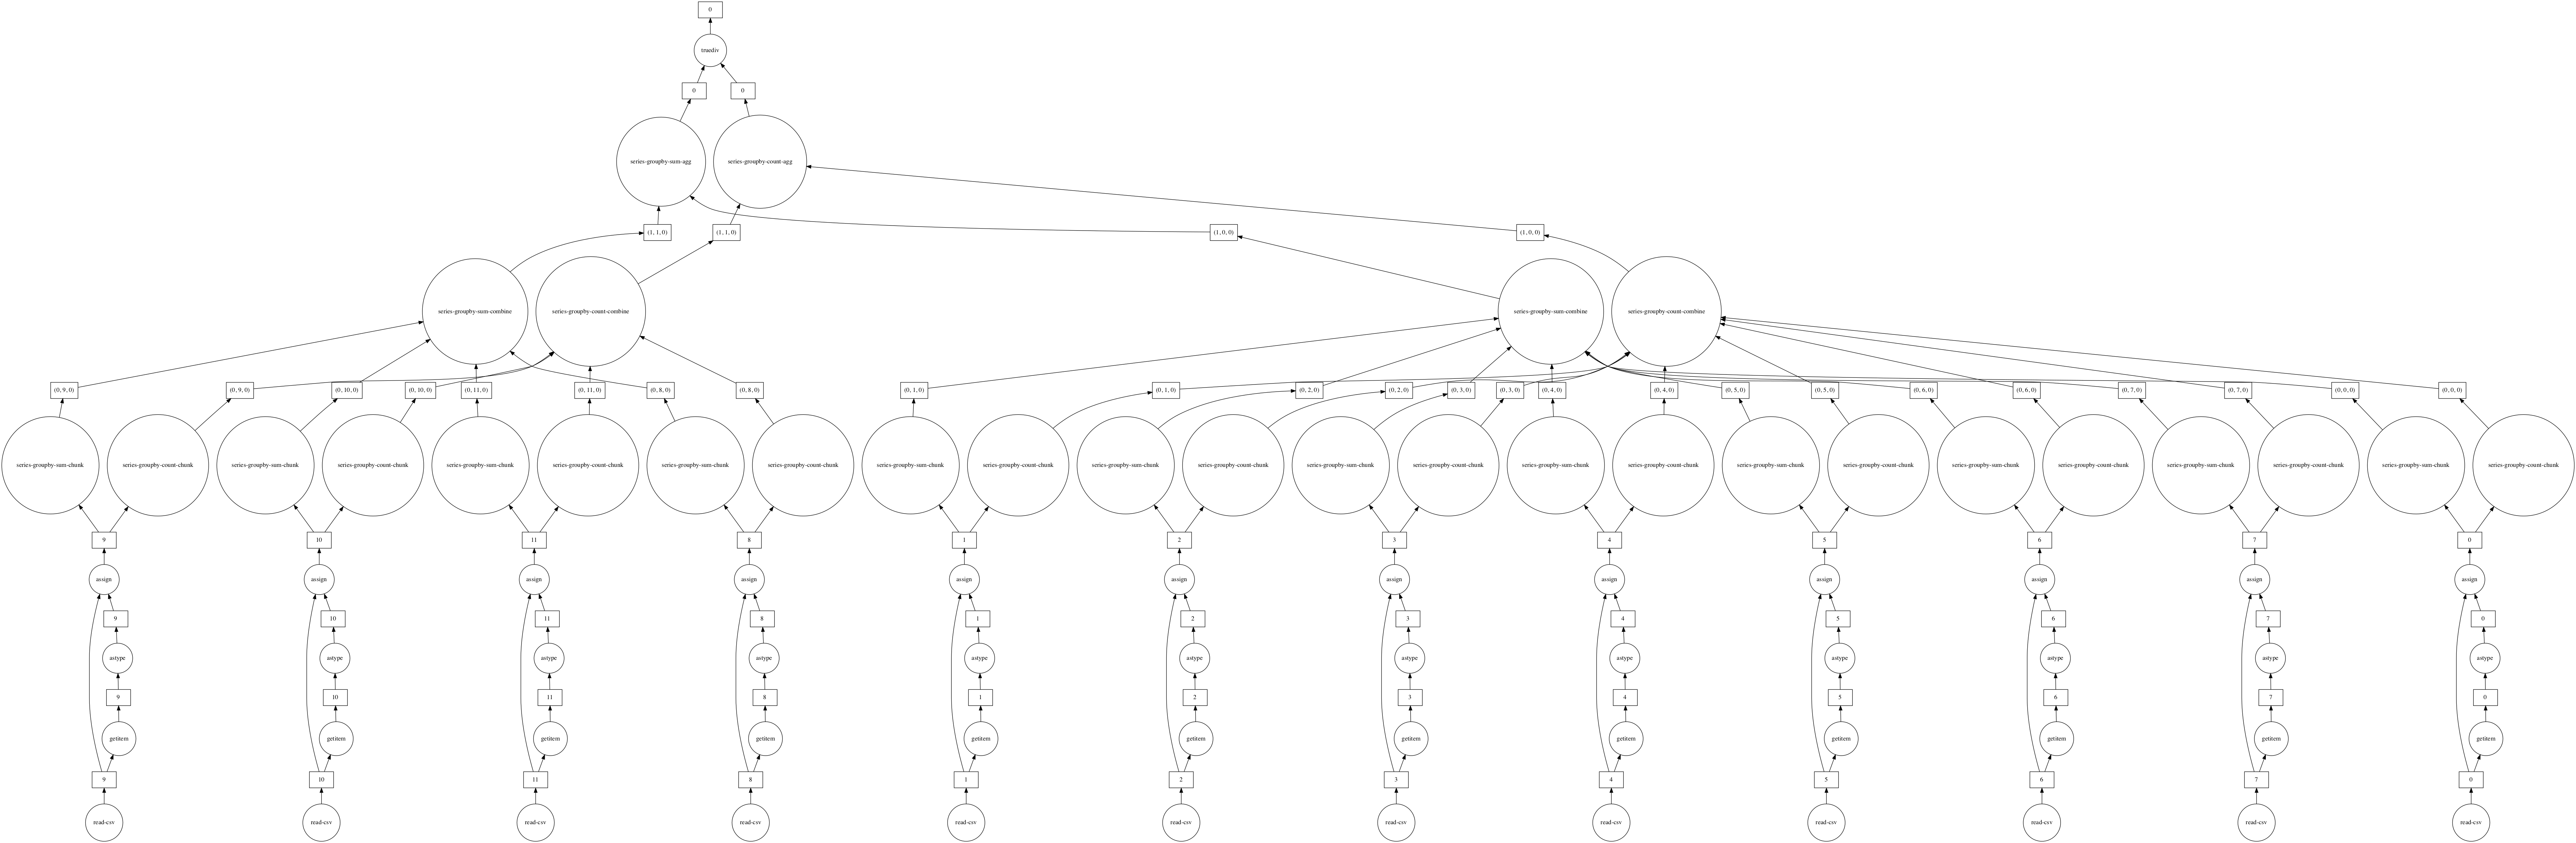

In [18]:
mean.visualize()

In [19]:
# add compute() at end to show result of calculation
df.groupby('Deliverer').TransferQtyInGallon.max().compute()

Deliverer
ALASKAN FRONTIER      27300000.0
ALASKAN NAVIGATOR     37800000.0
ALSEA BAY                 3500.0
AMERICAN ENDURANCE    12600000.0
AMERICAN FREEDOM       7980000.0
                         ...    
RAINIER                 155833.0
SAN DU AO               352019.0
Sea Voyager              70000.0
TUG GRIZZLE               3000.0
WHATCOM CHIEF             3000.0
Name: TransferQtyInGallon, Length: 339, dtype: float64

## Take aways:
- Pandas:
    - loop over file
    - then calculate values
- dask.delayed: 
    - still think about loops, intermediate results, then final reduction
- dask.dataframe:
    - reads multiple files at once
    - automatically parallelizes
    - large datasets partitioned into smaller dataframes
